# CSCE 689 HW2
## Rahaan Gandhi
## 434007427

In [ ]:
!pip install LIME

In [ ]:
pip install shap==0.44.1

## Part 1 and 2

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/CSCE 689/hw2/Employee.csv'
data = pd.read_csv(file_path)
data.head()

In [ ]:
categorical_cols = ['Education', 'City', 'EverBenched']
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

#### Drop protected attributes and split data for training and testing

In [ ]:
X = data.drop(columns=['Age', 'Gender', 'LeaveOrNot'])
y = data['LeaveOrNot']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Random Forest Classifier

In [ ]:
# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on test data
y_preds = rf_classifier.predict(X_test)
y_probas = rf_classifier.predict_proba(X_test)[:, 1]  # Probabilities for the calibration curve

#### Prepare test data for bias detection analysis

In [ ]:
# Add predictions and true Age, Gender values to the test data for bias detection analysis
X_test_biased = X_test.copy()
X_test_biased['Actual'] = y_test
X_test_biased['Predicted'] = y_preds
X_test_biased = X_test_biased.join(data[['Age', 'Gender']], how='left', rsuffix='_true')

#### Function calculate Metrics

In [ ]:
# Define function to calculate metrics
def calc_metrics(df, group_col, group_values):
    met = {}
    for value in group_values:
        df_group = df[df[group_col] == value]
        leave_rate = df_group['Actual'].mean()

        # Type 1 Error (False Positive Rate): FP / (FP + TN)
        false_pos = ((df_group['Actual'] == 0) & (df_group['Predicted'] == 1)).sum()
        true_neg = ((df_group['Actual'] == 0) & (df_group['Predicted'] == 0)).sum()
        type1_error_rate = false_pos / (false_pos + true_neg) if (false_pos + true_neg) > 0 else 0

        # Type 2 Error (False Negative Rate): FN / (FN + TP)
        false_neg = ((df_group['Actual'] == 1) & (df_group['Predicted'] == 0)).sum()
        true_pos = ((df_group['Actual'] == 1) & (df_group['Predicted'] == 1)).sum()
        type2_error_rate = false_neg / (false_neg + true_pos) if (false_neg + true_pos) > 0 else 0

        met[value] = {
            'Leave Rate': leave_rate,
            'Type 1 Error Rate': type1_error_rate,
            'Type 2 Error Rate': type2_error_rate
        }
    return met

#### Metrics for Age

In [ ]:
X_test_biased['AgeGroup'] = X_test_biased['Age'].apply(lambda x: '<30' if x < 30 else '>=30')
age_metrics = calc_metrics(X_test_biased, 'AgeGroup', ['<30', '>=30'])
age_metrics_df = pd.DataFrame(age_metrics).T  # Transpose to have groups as rows
print("Age Metrics:")
print(age_metrics_df)

Age Metrics:
      Leave Rate  Type 1 Error Rate  Type 2 Error Rate
<30     0.375679           0.057391           0.387283
>=30    0.273684           0.052174           0.376923


#### Metrics for Gender

In [ ]:
gender_metrics = calc_metrics(X_test_biased, 'Gender', data['Gender'].unique())
gender_metrics_df = pd.DataFrame(gender_metrics).T  # Transpose to have groups as rows
print("Gender Metrics:")
print(gender_metrics_df)

Gender Metrics:
        Leave Rate  Type 1 Error Rate  Type 2 Error Rate
Male      0.243276           0.056543           0.452261
Female    0.479239           0.053156           0.335740


#### function to plot calibration curves

In [ ]:
def plot_calibration_curves(y_true, y_probas, group_names):
    plt.figure(figsize=(8, 6))

    # Loop through each group to plot its calibration curve
    for group_name, group_condition in group_names.items():
        fraction_of_positives, mean_predicted_value = calibration_curve(y_true[group_condition], y_probas[group_condition], n_bins=10)
        plt.plot(mean_predicted_value, fraction_of_positives, label=f"{group_name}")

    # Plot the perfectly calibrated line
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration Curve')
    plt.legend()
    plt.show()

#### Plot calibration curves for <30 and >=30 employees

In [ ]:
# Create a dictionary to hold the condition for each group
group_conditions = {
    '<30': X_test_biased['AgeGroup'] == '<30',
    '>=30': X_test_biased['AgeGroup'] == '>=30'
}

# Call the function with actual labels and probabilities for each group
plot_calibration_curves(X_test_biased['Actual'], y_probas, group_conditions)

#### Plot calibration curves for male and female employees

In [ ]:
# Create a dictionary to hold the condition for each gender group
gender_conditions = {gender: X_test_biased['Gender'] == gender for gender in data['Gender'].unique()}

# Call the function with actual labels and probabilities for each gender group
plot_calibration_curves(X_test_biased['Actual'], y_probas, gender_conditions)

Combined Age and Gender Metrics:
              Leave Rate  Type 1 Error Rate  Type 2 Error Rate
Male_<30       0.288719           0.064516           0.456954
Male_>=30      0.162712           0.044534           0.437500
Female_<30     0.489950           0.044335           0.333333
Female_>=30    0.455556           0.071429           0.341463


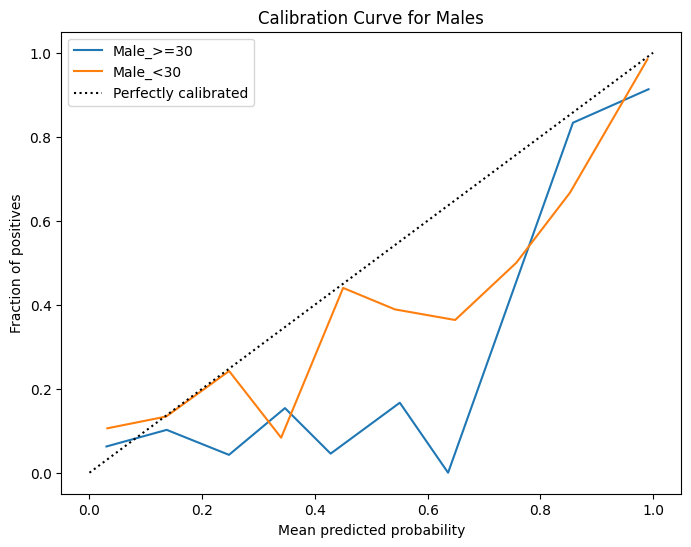

In [ ]:
# Create combined Age and Gender groups
X_test_biased['AgeGenderGroup'] = X_test_biased.apply(
    lambda x: f"{x['Gender']}_{'<30' if x['Age'] < 30 else '>=30'}", axis=1)
# Calculate and Print Metrics for Combined Age and Gender Groups
combo_grps = ['Male_<30', 'Male_>=30', 'Female_<30', 'Female_>=30']
combo_mets = calc_metrics(X_test_biased, 'AgeGenderGroup', combo_grps)
combo_mets_df = pd.DataFrame(combo_mets).T
print("Combined Age and Gender Metrics:\n", combo_mets_df)


def plot_calibration_curves_by_group(df, y_probas, title_suffix=''):
    plt.figure(figsize=(8, 6))
    for group_name in df['AgeGenderGroup'].unique():
        group_condition = df['AgeGenderGroup'] == group_name
        fraction_of_positives, mean_predicted_value = calibration_curve(df.loc[group_condition, 'Actual'], y_probas[group_condition], n_bins=10)

        plt.plot(mean_predicted_value, fraction_of_positives, label=group_name)

    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title(f'Calibration Curve {title_suffix}'.strip())
    plt.legend()
    plt.show()

y_probas_male = y_probas[X_test_biased['Gender'] == 'Male']
y_probas_female = y_probas[X_test_biased['Gender'] == 'Female']

# Now, you can call the function with properly aligned subsets.
plot_calibration_curves_by_group(X_test_biased[X_test_biased['Gender'] == 'Male'], y_probas_male, title_suffix='for Males')
plot_calibration_curves_by_group(X_test_biased[X_test_biased['Gender'] == 'Female'], y_probas_female, title_suffix='for Females')


## Part 3

### b. Using LIME

In [ ]:
import time
import warnings
warnings.filterwarnings('ignore')
import lime
import lime.lime_tabular

start = time.time()

# Create the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                   feature_names=X_train.columns,
                                                   class_names=['Not Leave', 'Leave'],
                                                   verbose=True, mode='classification')

# Choose a random instance to explain
i = 5
exp = explainer.explain_instance(X_test.values[i], rf_classifier.predict_proba, num_features=6)
exp.show_in_notebook(show_table=True)

end = time.time()

Intercept 0.5241528368877683
Prediction_local [0.52188003]
Right: 0.12634812409812407


In [ ]:
exp.as_list()
lime_time = end - start
print("LIME Analysis takes: ", lime_time, " seconds")

LIME Analysis takes:  0.27433061599731445  seconds


### Using SHAP

In [ ]:
import shap

start = time.time()
shap_explainer = shap.TreeExplainer(rf_classifier)
shap_values = shap_explainer.shap_values(X_test.iloc[i])

shap.initjs()
shap.force_plot(shap_explainer.expected_value[1], shap_values[1], X_test.iloc[i])

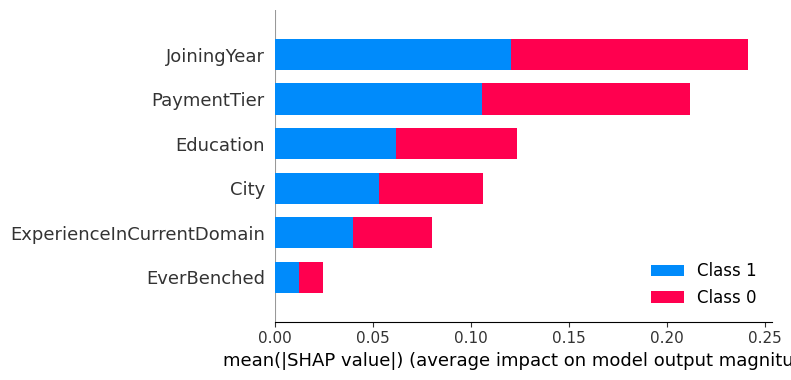

In [ ]:
shap_values = shap_explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
end = time.time()

In [ ]:
print(type(shap_values))
print(len(shap_values))
shap_time = end - start
print("SHAP Analysis takes: ", shap_time, " seconds")

<class 'list'>
2
SHAP Analysis takes:  43.25330138206482  seconds


## Part 4

### Visualizing LIME results

In [ ]:
exp.show_in_notebook(show_all=False)

### Visualizing SHAP results

(2, 1396, 6)


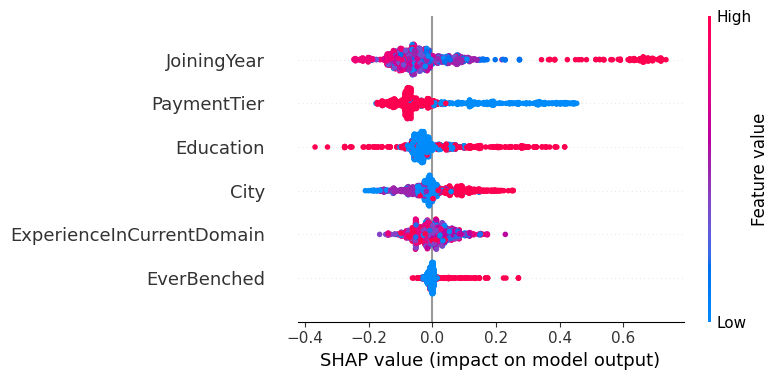

In [ ]:
shap_values = shap_explainer.shap_values(X_test)
print(np.array(shap_values).shape)
shap.summary_plot(shap_values[1], X_test)